# Семинар 6. Выбор модели. Кросс-валидация. Отбор признаков

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

RdGn = ListedColormap(['red', 'green'])
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 4)

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def regression_metrics(true, pred, verbose=False, plot=False):
    mae = mean_absolute_error(true, pred)
    mape = np.abs((true - pred) / true).mean()
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)

    if verbose:
        print('MAE: ', mae)
        print('MSE: ', mse)
        print('RMSE:', rmse)
        print('MAPE:', mape)
        print('R2:  ', r2)
        print()
    
    if plot:
        plt.figure(0, (6, 6))
        plt.scatter(true, pred)
        low = min(true.min(), pred.min())
        high = max(true.max(), pred.max())

        plt.plot([low, high], [low, high], color='blue')
        plt.xlabel('Ground Truth')
        plt.ylabel('Prediction')
        plt.show()
        
    return (mae, mse, rmse, mape, r2)

# Задача выбора модели

* __Настройка гиперпараметров:__ для конкретного вида модели выбрать наилучшие гиперпараметры (параметры обучения).
* __Выбор вида модели и алгоритма обучения:__ выбрать один из альтернативных видов модели.
* __Отбор признаков:__ отбросить неинформативные признаки.

# 1. Настройка гиперпараметров

Датасет __mpg__. По характеристикам машины необходимо спрогнозировать расход топлива.

Признаки:
* cylinders -- число цилиндров в двигателе;
* displacement -- рабочий объем, л;
* horsepower -- мощность, л.с.;
* weight -- вес, т;
* acceleration -- ускорение;
* model_year -- год выпуска модели;
* origin -- производитель;
* name -- название.

Целевая переменная:
* mpg -- миль на галлон, переведено в км/л.

In [3]:
frame = sns.load_dataset('mpg')
frame.dropna(inplace=True)

frame['displacement'] *= 16.3871 / 1000
frame['mpg'] = 100 / (frame.mpg * 1.60934 / 3.78541)
frame['weight'] *= 0.453592 / 1000

frame.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,13.067503,8,5.030840,130.0,1.589386,12.0,70,usa,chevrolet chevelle malibu
1,15.681004,8,5.735485,165.0,1.675115,11.5,70,usa,buick skylark 320
2,13.067503,8,5.211098,150.0,1.558542,11.0,70,usa,plymouth satellite
3,14.700941,8,4.981678,150.0,1.557181,12.0,70,usa,amc rebel sst
4,13.836180,8,4.948904,140.0,1.564439,10.5,70,usa,ford torino


Данные к обучению:

In [4]:
X = frame.drop(columns=['mpg', 'name']).copy()
y = frame.mpg.copy()

## 1.1. Метод отложенной выборки

* Делим датасет на 3 части:
    * __Train__ -- используется для обучения параметров модели.
    * __Valid__ -- используется для оценки обобщающей способности модели и для отбора гиперпараметров.
    * __Test__ -- используется для финальной оценки качества алгоритма.

In [5]:
from sklearn.model_selection import train_test_split


X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_fit, y_fit, test_size=0.1, random_state=42)

print('Train size:', X_train.shape[0])
print('Valid size:', X_valid.shape[0])
print('Test size:', X_test.shape[0])

Train size: 281
Valid size: 32
Test size: 79


Преобразование признаков и модель:

In [6]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']
cat_features = ['origin']

transformer = make_column_transformer((StandardScaler(), num_features), (OneHotEncoder(drop='first'), cat_features))
transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['displacement', 'horsepower', 'weight',
                                  'acceleration', 'cylinders', 'model_year']),
                                ('onehotencoder', OneHotEncoder(drop='first'),
                                 ['origin'])])

In [7]:
from sklearn.linear_model import Ridge


estimator = Ridge(alpha=1e-3)
estimator

Ridge(alpha=0.001)

In [8]:
from sklearn.pipeline import make_pipeline


model = make_pipeline(transformer, estimator)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)

Печатаем метрики:

Train:
MAE:  1.006571445629828
MSE:  1.8271676990014456
RMSE: 1.3517276719078608
MAPE: 0.09233814607795625
R2:   0.888276001098649

Valid:
MAE:  0.9333715744646405
MSE:  1.5088999890362045
RMSE: 1.2283729030861128
MAPE: 0.09445970413429362
R2:   0.8083766114966353



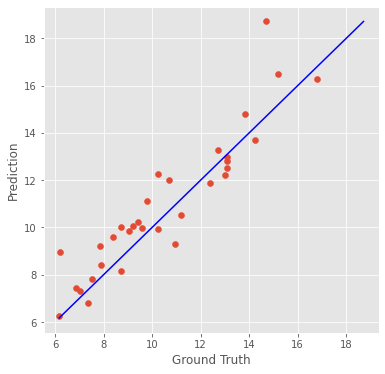

(0.9333715744646405,
 1.5088999890362045,
 1.2283729030861128,
 0.09445970413429362,
 0.8083766114966353)

In [9]:
print('Train:')
regression_metrics(y_train, pred_train, verbose=True)

print('Valid:')
regression_metrics(y_valid, pred_valid, verbose=True, plot=True)

Выбор гиперпараметров:


Best alpha: 44.22514763163044
Idx of best alpha: 118


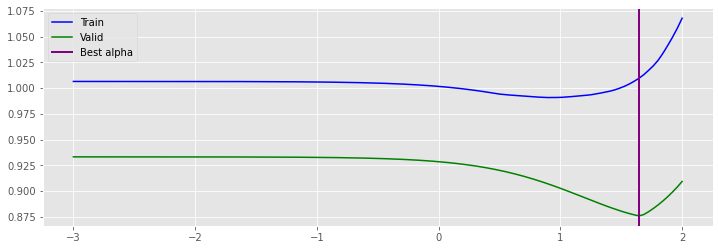

In [10]:
# Best MAE
from tqdm.auto import tqdm


def func(alpha):
    model = make_pipeline(transformer, Ridge(alpha=alpha))
    model.fit(X_train, y_train)
    
    score = mean_absolute_error
    
    metrics_train = score(y_train, model.predict(X_train))
    metrics_valid = score(y_valid, model.predict(X_valid))
    return metrics_train, metrics_valid

alpha_list = np.logspace(-3, 2, 128)
metrics_list = [func(alpha) for alpha in tqdm(alpha_list)]
train_list, valid_list = zip(*metrics_list)

best_idx = np.argmin(valid_list)
alpha_best = alpha_list[best_idx]
print('Best alpha:', alpha_best)
print('Idx of best alpha:', best_idx)

plt.plot(np.log10(alpha_list), train_list, color='blue', label='Train')
plt.plot(np.log10(alpha_list), valid_list, color='green', label='Valid')
plt.axvline(np.log10(alpha_best), color='purple', lw=2, label='Best alpha')
plt.legend()
plt.show()

Обучаем итоговую модель:

In [11]:
estimator = Ridge(alpha=alpha_best)

model = make_pipeline(transformer, estimator)
model.fit(X_fit, y_fit)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('ridge', Ridge(alpha=44.22514763163044))])

Fit:
MAE:  0.9926126530297397
MSE:  1.9492897682964863
RMSE: 1.3961696774735104
MAPE: 0.09046292873991102
R2:   0.8746388419325971

Test:
MAE:  0.9272767346617401
MSE:  1.6592567207775446
RMSE: 1.2881213920968568
MAPE: 0.08099501762559658
R2:   0.8829842270316929



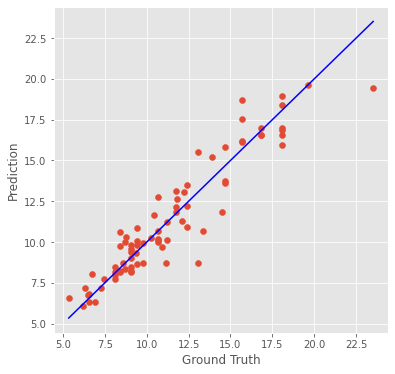

(0.9272767346617401,
 1.6592567207775446,
 1.2881213920968568,
 0.08099501762559658,
 0.8829842270316929)

In [12]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

## 1.2. Кросс-валидация

Цели:
* Выбор модели.
* Оценка качества.

Основные разновидности кросс-валидации:
* __Leave One Out:__ 
    * по очереди откладываем одно наблюдение для оценки;
    * обучаем на всей выборке кроме выбранного наблюдения;
    * считаем метрики на отложенном наблюдении.
* __K-Fold:__
    * делим на $k$ непересекающихся групп (fold-ов);
    * далее аналогично Leave One Out.
* __Repeated K-Fold:__
    * несколько раз с разными разбиениями повторяется K-Fold.
* __Stratified K-Fold:__
    * Разбиения пропорционально категориальному признаку (распределение по категориям в fold-ах будет похожим).
* __Grouped K-Fold:__
    * Если одному объекту принадлежит несколько наблюдений (например, пользователь померил несколько моделей обуви).

In [13]:
X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Fit size:', X_fit.shape[0])
print('Test size:', X_test.shape[0])

Fit size: 313
Test size: 79


$L_2$-регуляризация с кросс-валидацией:

In [14]:
from sklearn.linear_model import RidgeCV


estimator = RidgeCV(alphas=np.logspace(-3, 2, 64))
model = make_pipeline(transformer, estimator)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-03, 1.20050806e-03, 1.44121960e-03, 1.73019574e-03,
       2.07711393e-0...
       1.49486913e+00, 1.79460244e+00, 2.15443469e+00, 2.58641621e+00,
       3.10501350e+00, 3.72759372e+00, 4.47500630e+00, 5.37228112e+00,
       6.44946677e+00, 7.74263683e+00, 9.29509790e+00, 1.11588399e+01,
       1

Настраиваем гиперпараметры и смотрим на качество модели:

In [15]:
model.fit(X_fit, y_fit)

print('Best alpha:', model['ridgecv'].alpha_)
print('Coefs:', model['ridgecv'].coef_)

Best alpha: 2.154434690031882
Coefs: [-0.49562088  1.08978765  1.979628    0.23120289  0.58091994 -1.1687093
  0.15679769  0.77167686]


Fit:
MAE:  0.9853606796922143
MSE:  1.793282315748987
RMSE: 1.3391349131991843
MAPE: 0.09092546627850533
R2:   0.8846718679283121

Test:
MAE:  0.9718889261132576
MSE:  1.5602084197689168
RMSE: 1.2490830315751298
MAPE: 0.08740506806215782
R2:   0.8899694110352212



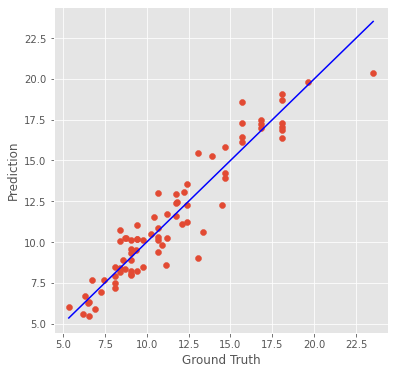

(0.9718889261132576,
 1.5602084197689168,
 1.2490830315751298,
 0.08740506806215782,
 0.8899694110352212)

In [20]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

# 1.3. GridSearch

Умеет перебирать все возможные гипер-параметры и находить оптимальные для произвольных алгоритмов машинного обучения.

In [21]:
X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Fit size:', X_fit.shape[0])
print('Test size:', X_test.shape[0])

Fit size: 313
Test size: 79


In [22]:
from sklearn.model_selection import GridSearchCV


grid_search = GridSearchCV(Ridge(), {
    'alpha': np.logspace(-3, 2, 32),
    'solver': ('svd', 'cholesky', 'lsqr')
})

model = make_pipeline(transformer, grid_search)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('gridsearchcv',
                 GridSearchCV(estimator=Ridge(),
                              param_grid={'alpha': array([1.00000000e-03, 1.44974067e-03, 2....
       1.95129342e-02, 2.82886943e-02, 4.10112707e-02, 5.94557071e-02,
       8.61953566e-02, 1.24960914e-01, 1.81160919e-01, 2.62636353e-01,
       3.80754602e-01, 5.51995432e-01, 8.00250228e-01, 1

In [24]:
model.fit(X_fit, y_fit)
model['gridsearchcv'].best_estimator_

Ridge(alpha=3.5349811050301057, solver='lsqr')

Fit:
MAE:  0.9821045073900578
MSE:  1.7984240143652217
RMSE: 1.3410533227151042
MAPE: 0.09053643858574437
R2:   0.8843411991362997

Test:
MAE:  0.9669734151838609
MSE:  1.563113057319108
RMSE: 1.2502451988786472
MAPE: 0.08670568544974248
R2:   0.889764567261577



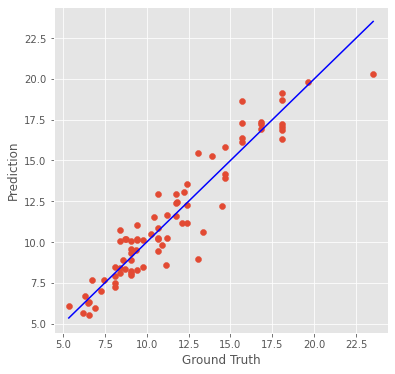

(0.9669734151838609,
 1.563113057319108,
 1.2502451988786472,
 0.08670568544974248,
 0.889764567261577)

In [25]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

GridSearch для всего пайплайна:

In [34]:
2 * 32 * 3 * 5

960

In [32]:
model = make_pipeline(transformer, Ridge())
gs = GridSearchCV(model, {
    'columntransformer__onehotencoder__drop': [None, 'first'],
    'ridge__alpha': np.logspace(-3, 2, 32),
    'ridge__solver': ('svd', 'cholesky', 'lsqr')
})
gs.fit(X_fit, y_fit)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['displacement',
                                                                          'horsepower',
                                                                          'weight',
                                                                          'acceleration',
                                                                          'cylinders',
                                                                          'model_year']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                    

In [39]:
gs.best_params_

{'columntransformer__onehotencoder__drop': None,
 'ridge__alpha': 3.5349811050301057,
 'ridge__solver': 'svd'}

In [44]:
# pred_fit = gs.predict(X_fit)
# pred_test = gs.predict(X_test)

Fit:
MAE:  0.9832754530696698
MSE:  1.797131812147926
RMSE: 1.3405714498481331
MAPE: 0.09063299164240088
R2:   0.8844243022075066

Test:
MAE:  0.9694082525755595
MSE:  1.5680772283548081
RMSE: 1.2522289041364634
MAPE: 0.0869331375880883
R2:   0.8894144789939719



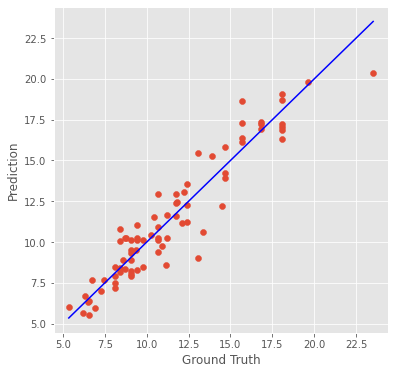

(0.9694082525755595,
 1.5680772283548081,
 1.2522289041364634,
 0.0869331375880883,
 0.8894144789939719)

In [43]:
print('Fit:')
regression_metrics(y_fit, gs.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, gs.predict(X_test), verbose=True, plot=True)

In [37]:
from sklearn.pipeline import Pipeline


model = Pipeline([
    ('trans', transformer),
    ('m', Ridge())
])
model

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('m', Ridge())])

# 2. Выбор вида модели

__Задача:__ отобрать параметры для метода $k$ ближайших соседей.

In [46]:
from sklearn.neighbors import KNeighborsRegressor


model = Pipeline([
    ('trans', transformer),
    ('knn', KNeighborsRegressor())
])
gs = GridSearchCV(model, {
    'knn__n_neighbors': [1, 2, 5, 10, 19],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2, 3]
})
gs.fit(X_fit, y_fit)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['displacement',
                                                                          'horsepower',
                                                                          'weight',
                                                                          'acceleration',
                                                                          'cylinders',
                                                                          'model_year']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                

In [47]:
gs.best_params_

{'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}

Fit:
MAE:  0.0
MSE:  0.0
RMSE: 0.0
MAPE: 0.0
R2:   1.0

Test:
MAE:  0.8241353781715858
MSE:  1.2314486786561292
RMSE: 1.1097065732238092
MAPE: 0.07319595554370363
R2:   0.9131545364865413



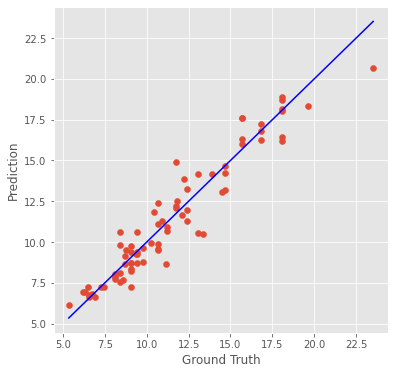

(0.8241353781715858,
 1.2314486786561292,
 1.1097065732238092,
 0.07319595554370363,
 0.9131545364865413)

In [48]:
print('Fit:')
regression_metrics(y_fit, gs.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, gs.predict(X_test), verbose=True, plot=True)

__Задача:__ 
* обучить понравившуюся Вам модель и подобрать к ней гиперпараметры;
* выбрать метрику качества и сравнить с KNN.

# 3. Отбор признаков

Sklearn обладает инструментами для отбора признаков ([ссылка на документацию](https://scikit-learn.org/stable/modules/feature_selection.html)).

* Удаление признаков с малой дисперсией.
* Отбор признаков с помощью статистических критериев.
* С помощью $L_1$ регуляризации.
* Рекурсивный отбор признаков.
* Последовательный отбор признаков.

In [52]:
from sklearn.feature_selection import (
    f_regression,
    SelectKBest,
    SelectFromModel,
    RFE,
#     SequentialFeatureSelector
)

Выбор с помощью модели:

In [55]:
from sklearn.linear_model import LinearRegression


features = np.random.normal(size=(128, 16))
targets = 0.1 + 0.05 * features[:, 0] + 0.02 * features[:, 2] - 0.1 * features[:, 4] + np.random.normal(scale=1)

In [56]:
selector = SelectFromModel(LinearRegression(), max_features=16)
selector.fit(features, targets)

display(selector.get_support())
selector.transform(features)[:5]

array([ True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False])

array([[-1.01193709,  0.91892059,  0.6291351 ],
       [ 0.66358266, -0.86957966, -0.37586812],
       [ 0.48259042, -0.62251868, -1.20095126],
       [-0.79382146, -0.36947453,  0.53310708],
       [ 0.31611497, -0.77965813,  1.41118183]])

Рекурсивный отбор признаков:

In [58]:
selector = RFE(LinearRegression(), n_features_to_select=6)
selector.fit(features, targets)

display(selector.get_support())
selector.transform(features)[:5]

array([ True, False,  True,  True,  True,  True, False, False, False,
       False, False, False, False,  True, False, False])

array([[-1.01193709,  0.91892059,  0.00388137,  0.6291351 ,  0.98106712,
         0.12213894],
       [ 0.66358266, -0.86957966,  0.13706136, -0.37586812,  1.17743387,
         0.12132024],
       [ 0.48259042, -0.62251868,  0.01165475, -1.20095126,  0.17246103,
        -1.7195937 ],
       [-0.79382146, -0.36947453,  0.83073019,  0.53310708,  0.74668525,
         1.60909588],
       [ 0.31611497, -0.77965813, -0.91784533,  1.41118183,  0.30080383,
        -1.21646221]])

In [ ]:
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3)
selector.fit(features, targets)

display(selector.get_support())
selector.transform(features)[:5]

Встраиваем в Pipeline:

Fit:
MAE:  1.0018041818601027
MSE:  1.8812190392068615
RMSE: 1.3715753859000466
MAPE: 0.09219059870465736
R2:   0.879016551992926

Test:
MAE:  0.9380611803107162
MSE:  1.4788264808266893
RMSE: 1.2160700970037415
MAPE: 0.08266362250396754
R2:   0.8957087100669718



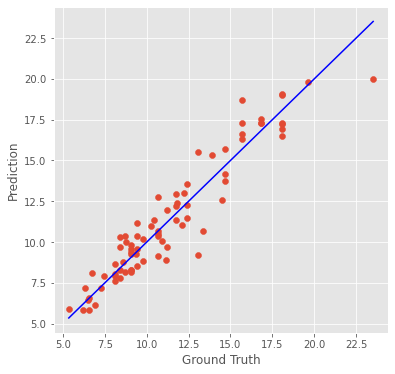

(0.9380611803107162,
 1.4788264808266893,
 1.2160700970037415,
 0.08266362250396754,
 0.8957087100669718)

In [59]:
selector = SelectKBest(score_func=f_regression, k=5)
estimator = LinearRegression()

model = make_pipeline(transformer, selector, estimator)
model.fit(X_fit, y_fit)

print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True, plot=True)

In [60]:
selector = SelectKBest(score_func=f_regression, k=1)
estimator = Ridge()

pipeline = make_pipeline(transformer, selector, estimator)
pipeline.fit(X_fit, y_fit)

model = GridSearchCV(pipeline, {
    'ridge__alpha': np.logspace(-4, 3, 16),
    'ridge__fit_intercept': [False, True],
    'columntransformer__standardscaler__with_mean': [False, True],
    'selectkbest__k': list(range(1, 9))
}, verbose=1, n_jobs=16)
model.fit(X_fit, y_fit)
model.best_estimator_

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.0s
[Parallel(n_jobs=16)]: Done 341 tasks      | elapsed:    7.6s
[Parallel(n_jobs=16)]: Done 1332 tasks      | elapsed:   13.5s
[Parallel(n_jobs=16)]: Done 2529 out of 2560 | elapsed:   18.9s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 2560 out of 2560 | elapsed:   19.0s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(with_mean=False),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'acceleration',
                                                   'cylinders', 'model_year']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['origin'])])),
                ('selectkbest',
                 SelectKBest(k=7,
                             score_func=<function f_regression at 0x000001B010B60B80>)),
                ('ridge', Ridge(alpha=4.641588833612782))])

In [62]:
model.best_params_

{'columntransformer__standardscaler__with_mean': False,
 'ridge__alpha': 4.641588833612782,
 'ridge__fit_intercept': True,
 'selectkbest__k': 7}

In [63]:
print('Fit:')
regression_metrics(y_fit, model.predict(X_fit), verbose=True)

print('Test:')
regression_metrics(y_test, model.predict(X_test), verbose=True)

Fit:
MAE:  0.9802459043063996
MSE:  1.805649638037952
RMSE: 1.3437446327475888
MAPE: 0.0904115641534019
R2:   0.8838765106296933

Test:
MAE:  0.962844266556016
MSE:  1.5684902616403231
RMSE: 1.2523938125207754
MAPE: 0.08626568213433244
R2:   0.8893853506447773



(0.962844266556016,
 1.5684902616403231,
 1.2523938125207754,
 0.08626568213433244,
 0.8893853506447773)

# 4. Оценка качества модели на кросс-валидации

In [64]:
estimator = Ridge(alpha=0.01)
model = make_pipeline(transformer, estimator)

In [68]:
from sklearn.neighbors import KNeighborsRegressor


model_ = Pipeline([
    ('trans', transformer),
    ('knn', KNeighborsRegressor())
])
model = GridSearchCV(model_, {
    'knn__n_neighbors': [1, 2, 5, 10, 19],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2, 3]
})
# model.fit(X_fit, y_fit)

In [69]:
from sklearn.model_selection import KFold


cv = KFold(n_splits=5, shuffle=True, random_state=42)

metrics = []

for fit_index, test_index in cv.split(X, y):
    X_fit = X.iloc[fit_index]
    X_test = X.iloc[test_index]
    
    y_fit = y.iloc[fit_index]
    y_test = y.iloc[test_index]
    
    model.fit(X_fit, y_fit)
    pred_test = model.predict(X_test)
    
    metrics.append(regression_metrics(y_test, pred_test))
    
metrics = pd.DataFrame(metrics, columns=['mae', 'mse', 'rmse', 'mape', 'r2'])
metrics

,mae,mse,rmse,mape,r2
0,0.878951,1.386486,1.177491,0.079065,0.902221
1,0.998709,1.656181,1.286927,0.092029,0.868772
2,1.021780,2.084007,1.443609,0.096138,0.883266
3,0.968795,1.974579,1.405197,0.086816,0.887352
4,0.861617,1.255160,1.120339,0.086303,0.906286


In [70]:
metrics.mean()

mae     0.945971
mse     1.671283
rmse    1.286713
mape    0.088070
r2      0.889579
dtype: float64

Из коробки:

In [74]:
from sklearn.model_selection import cross_val_score


cv_result = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
cv_result

array([-1.38648566, -1.65618138, -2.08400721, -1.97457854, -1.25515998])

In [72]:
cv_result.mean()

-1.6712825543631893

Несколько метрик:

In [75]:
from sklearn.model_selection import cross_validate


cv_result = cross_validate(model, X, y, cv=cv, 
                           scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])
cv_result

{'fit_time': array([2.15089726, 2.22330642, 2.12085247, 1.99201846, 2.10065579]),
 'score_time': array([0.00365829, 0.0059998 , 0.0049963 , 0.02189183, 0.        ]),
 'test_neg_mean_absolute_error': array([-0.87895097, -0.99870914, -1.02178034, -0.96879481, -0.86161734]),
 'test_neg_mean_squared_error': array([-1.38648566, -1.65618138, -2.08400721, -1.97457854, -1.25515998]),
 'test_r2': array([0.90222086, 0.86877158, 0.88326607, 0.88735244, 0.90628637])}

In [76]:
{k: np.mean(v) for k, v in cv_result.items()}

{'fit_time': 2.1175460815429688,
 'score_time': 0.007309246063232422,
 'test_neg_mean_absolute_error': -0.9459705194131842,
 'test_neg_mean_squared_error': -1.6712825543631893,
 'test_r2': 0.8895794659378218}